In [1]:
# import required libraries
import warnings
warnings.filterwarnings("ignore")

In [2]:
%load_ext tensorboard

In [3]:
import re
import os 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
import tensorflow as tf 
from pathlib import Path
from tqdm import tqdm
from datetime import datetime

In [4]:
data_dir = "data/train_val/"

In [5]:
# get to know whats inside the data
os.listdir(data_dir)

['val', 'train']

In [6]:
# initialize image sizes and parameters
HEIGHT = 224
WIDTH = 224
CHANNELS = 3
BATCH_SIZE = 32

In [7]:
os.listdir(data_dir + "train")

['leaf_rust', 'stem_rust', 'healthy_wheat']

# process the data with tf.data 


In [9]:
# a function to show the image batch
def show_batch(image_batch, label_batch):
  plt.figure(figsize=(10,10))
  for n in range(25):
      ax = plt.subplot(5,5,n+1)
      plt.imshow(image_batch[n])
      plt.title(CLASS_NAMES[label_batch[n]==1][0].title())
      plt.axis('off')

In [10]:
# get the number of images
train_image_count = len(list(Path(data_dir + "train").glob('*/*')))
val_image_count = len(list(Path(data_dir + "val").glob('*/*')))
print(train_image_count)
val_image_count

2098


177

In [11]:
# train data
train_list_ds = tf.data.Dataset.list_files(str(data_dir + "train/" +'*/*'))
# validation data
val_list_ds = tf.data.Dataset.list_files(str(data_dir + "val/" +'*/*'))

In [12]:
# images class names
CLASS_NAMES = np.array([item.name for item in Path(data_dir + "train").glob('*')])
CLASS_NAMES

array(['leaf_rust', 'stem_rust', 'healthy_wheat'], dtype='<U13')

In [13]:
for f in train_list_ds.take(5):
  print(f.numpy())

b'data/train_val/train/stem_rust/stem_rust192_.png'
b'data/train_val/train/stem_rust/stem_rust276_.png'
b'data/train_val/train/stem_rust/stem_rust27_.png'
b'data/train_val/train/stem_rust/EEO09F.JPG'
b'data/train_val/train/stem_rust/8W7Q5X.JPG'


In [14]:
# read image 
# a function to read data
def read_image(img_path):
    img_loader = tf.io.read_file(img_path)
    img_decoder = tf.image.decode_jpeg(img_loader, channels=CHANNELS)
    img = tf.image.convert_image_dtype(img_decoder, tf.float32)
    img = tf.image.resize(img, [WIDTH, HEIGHT])
    return img

In [15]:
# To get labels
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == CLASS_NAMES

In [16]:
# process paths
def process_path(file_path):
    label = get_label(file_path)
    img = read_image(file_path)
    return img, label

In [17]:
# using tensorflow dataset.map to create a dataset of image, label pairs
train_labeled_ds = train_list_ds.map(process_path, num_parallel_calls=-1)
val_labeled_ds = val_list_ds.map(process_path, num_parallel_calls=-1)

In [18]:
for image, label in train_labeled_ds.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())

Image shape:  (224, 224, 3)
Label:  [False  True False]


In [19]:
# prepare data for training 
def prepare_for_training(ds, shuffle_buffer_size=100, training=True):
  ds = ds.shuffle(buffer_size=shuffle_buffer_size)

  # Repeat forever
  if training:
    ds = ds.repeat()
    print("repeating")
  else:
    pass
  ds = ds.batch(BATCH_SIZE)

  # `prefetch` lets the dataset fetch batches in the background while the model
  # is training.
  ds = ds.prefetch(buffer_size=-1)

  return ds

In [20]:
train_ds = prepare_for_training(train_labeled_ds)
val_ds = prepare_for_training(val_labeled_ds, training=False)
image_batch, label_batch = next(iter(train_ds))

repeating


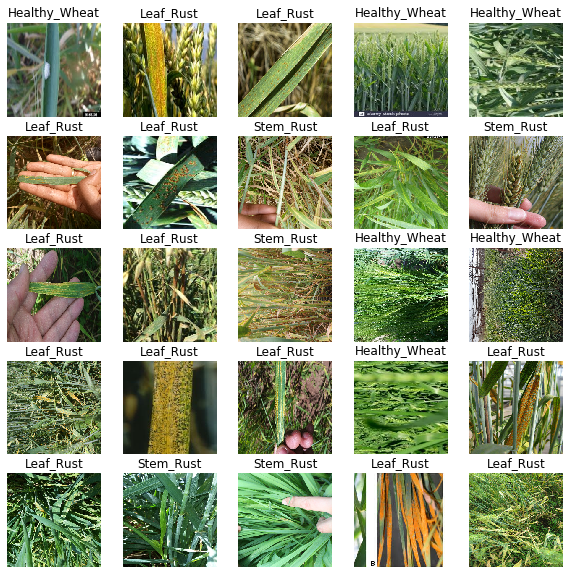

In [21]:
show_batch(image_batch.numpy(), label_batch.numpy())

In [22]:
# prepare the test data
test_list = "data/test"

In [23]:
test_list_ds = tf.data.Dataset.list_files(str(test_list +'*/*'))

In [24]:
# test list file names
for f in test_list_ds.take(5):
  print(f.numpy())

b'data/test/K4KG21.jfif'
b'data/test/085IEC.jpg'
b'data/test/OHDGS7.jfif'
b'data/test/URXE6M.jpg'
b'data/test/7VKX0H.jfif'


In [25]:
# process test
def process_test(image_path):
    img = read_image(image_path)
    return img, image_path

In [26]:
test_ds = test_list_ds.map(process_test, num_parallel_calls=-1)

(224, 224, 3)
b'data/test/U2GLZO.jpg'


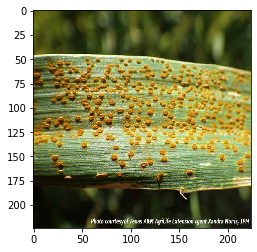

In [27]:
for i, j in test_ds.take(1):
    print(i.numpy().shape)
    print(j.numpy())
    plt.imshow(i.numpy())

# create callbacks

In [28]:
# temsorboard
log_dir="logs/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# Early stopping
es = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=3)

# model checkpoints
checkpoint_path =  "model/" + datetime.now().strftime("%Y%m%d-%H%M%S") + "/cp.ckpt"
model_checkpoints = tf.keras.callbacks.ModelCheckpoint(
            checkpoint_path,
            save_best_only=True,
            save_weights_only=True,
            monitor='val_categorical_accuracy',
            mode='max')

In [29]:
callbacks = [tensorboard, es, model_checkpoints]

In [32]:
# define class weights
leaf_rust_count = 859
stem_rust_count = 900
healthy_wheat_count = 339
total = leaf_rust_count + stem_rust_count + healthy_wheat_count

leaf_rust_weight = (1/leaf_rust_count) * (total) / 3.0
stem_rust_weight = (1/stem_rust_count) * (total) / 3.0
healthy_wheat_weight = (1/healthy_wheat_count) * (total) / 3.0

class_weight = {0:leaf_rust_weight, 1:stem_rust_weight, 2:healthy_wheat_weight}
print(class_weight)

{0: 0.8141249514939853, 1: 0.777037037037037, 2: 2.062930186823992}


#  create a simple model

In [59]:
def simple_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(32, (3,3), activation="relu", input_shape=(224, 224, 3)))
    model.add(tf.keras.layers.MaxPool2D(2,2, padding="same"))
    model.add(tf.keras.layers.GlobalAveragePooling2D())
    model.add(tf.keras.layers.Dense(256, activation="softmax"))
    model.add(tf.keras.layers.Dense(3, activation="softmax"))
    model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.01), 
                    loss=tf.keras.losses.categorical_crossentropy, 
                    metrics = [tf.keras.metrics.categorical_accuracy])
    return model 

In [60]:
steps_per_epoch = train_image_count // BATCH_SIZE
validation_steps = val_image_count // BATCH_SIZE
print(steps_per_epoch)
validation_steps

65


5

In [61]:
# fit the model
model = simple_model()

In [62]:
model.fit(train_ds, epochs=100, steps_per_epoch=steps_per_epoch, 
                validation_data=val_ds, validation_steps=validation_steps,
                callbacks=callbacks, class_weight=class_weight)

Train for 65 steps, validate for 5 steps
Epoch 1/100
65/65 [==============================] - 28s 426ms/step - loss: 1.0339 - categorical_accuracy: 0.4284 - val_loss: 1.0033 - val_categorical_accuracy: 0.4563
Epoch 2/100
65/65 [==============================] - 26s 399ms/step - loss: 1.0254 - categorical_accuracy: 0.4192 - val_loss: 1.0203 - val_categorical_accuracy: 0.4750
Epoch 3/100
65/65 [==============================] - 26s 396ms/step - loss: 1.0114 - categorical_accuracy: 0.4894 - val_loss: 0.9885 - val_categorical_accuracy: 0.5750
Epoch 4/100
65/65 [==============================] - 27s 415ms/step - loss: 1.0043 - categorical_accuracy: 0.4827 - val_loss: 0.9666 - val_categorical_accuracy: 0.5625
Epoch 5/100
65/65 [==============================] - 24s 376ms/step - loss: 0.9623 - categorical_accuracy: 0.5149 - val_loss: 0.9154 - val_categorical_accuracy: 0.5500
Epoch 6/100
65/65 [==============================] - 25s 389ms/step - loss: 0.9353 - categorical_accuracy: 0.5221 - val

In [41]:
# create a deeper layer
def deeper_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(32, (5,5), activation="relu", input_shape=(224, 224, 3),
                                    kernel_initializer="he_uniform"))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.MaxPool2D(2,2, padding="same"))

    model.add(tf.keras.layers.Conv2D(64, (3,3), activation="relu", kernel_initializer="he_uniform"))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.MaxPool2D(2,2, padding="same"))

    # model.add(tf.keras.layers.Dense(256, activation="relu"))

    model.add(tf.keras.layers.GlobalAveragePooling2D())
    model.add(tf.keras.layers.Dense(3, activation="softmax"))
    model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.01), 
                    loss=tf.keras.losses.categorical_crossentropy, 
                    metrics = [tf.keras.metrics.categorical_accuracy])
    return model 

In [42]:
deeper_model = deeper_model()

In [43]:
deeper_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 220, 220, 32)      2432      
_________________________________________________________________
batch_normalization_2 (Batch (None, 220, 220, 32)      128       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 110, 110, 32)      0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 108, 108, 64)      18496     
_________________________________________________________________
batch_normalization_3 (Batch (None, 108, 108, 64)      256       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________________________________
global_average_pooling2d_2 ( (None, 64)               

In [44]:
deeper_model.fit(train_ds, epochs=100, steps_per_epoch=steps_per_epoch, 
                validation_data=val_ds, validation_steps=validation_steps,
                callbacks=callbacks)

Train for 65 steps, validate for 5 steps
Epoch 1/100
65/65 [==============================] - 29s 451ms/step - loss: 0.8971 - categorical_accuracy: 0.5591 - val_loss: 1.3627 - val_categorical_accuracy: 0.4750
Epoch 2/100
65/65 [==============================] - 27s 412ms/step - loss: 0.8523 - categorical_accuracy: 0.6010 - val_loss: 1.2172 - val_categorical_accuracy: 0.4125
Epoch 3/100
65/65 [==============================] - 26s 403ms/step - loss: 0.8295 - categorical_accuracy: 0.5942 - val_loss: 1.1254 - val_categorical_accuracy: 0.4688
Epoch 4/100
65/65 [==============================] - 26s 394ms/step - loss: 0.8096 - categorical_accuracy: 0.6149 - val_loss: 1.3211 - val_categorical_accuracy: 0.4437
Epoch 5/100
65/65 [==============================] - 25s 380ms/step - loss: 0.7907 - categorical_accuracy: 0.6245 - val_loss: 1.2405 - val_categorical_accuracy: 0.4250
Epoch 6/100
65/65 [==============================] - 26s 394ms/step - loss: 0.7839 - categorical_accuracy: 0.6394 - val

# Transfer Learning

In [45]:
IMG_SHAPE = (HEIGHT, WIDTH, CHANNELS)

# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [46]:
base_model.trainable = False

In [47]:
pretrained_model = tf.keras.Sequential([
base_model,
tf.keras.layers.GlobalAveragePooling2D(),
tf.keras.layers.Dense(3, activation="softmax")
])

pretrained_model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.01), 
            loss=tf.keras.losses.categorical_crossentropy, 
            metrics = [tf.keras.metrics.categorical_accuracy])

In [48]:
pretrained_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_3 ( (None, 1280)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 3843      
Total params: 2,261,827
Trainable params: 3,843
Non-trainable params: 2,257,984
_________________________________________________________________


In [49]:
len(pretrained_model.trainable_variables)

2

In [50]:
pretrained_model.fit(train_ds, epochs=5, steps_per_epoch=steps_per_epoch, 
                validation_data=val_ds, validation_steps=validation_steps,
                callbacks=callbacks)

Train for 65 steps, validate for 5 steps
Epoch 1/5
65/65 [==============================] - 32s 496ms/step - loss: 0.8302 - categorical_accuracy: 0.6923 - val_loss: 0.9379 - val_categorical_accuracy: 0.7000
Epoch 2/5
65/65 [==============================] - 27s 422ms/step - loss: 0.5930 - categorical_accuracy: 0.7774 - val_loss: 1.4518 - val_categorical_accuracy: 0.6125
Epoch 3/5
65/65 [==============================] - 26s 403ms/step - loss: 0.4337 - categorical_accuracy: 0.8308 - val_loss: 1.0327 - val_categorical_accuracy: 0.6562
Epoch 4/5
65/65 [==============================] - 27s 413ms/step - loss: 0.4737 - categorical_accuracy: 0.8284 - val_loss: 1.1509 - val_categorical_accuracy: 0.6500


In [51]:
# fine tune the model
base_model.trainable = True

In [52]:
# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

In [53]:
pretrained_model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.01), 
            loss=tf.keras.losses.categorical_crossentropy, 
            metrics = [tf.keras.metrics.categorical_accuracy])

In [54]:
pretrained_model.fit(train_ds, epochs=100, steps_per_epoch=steps_per_epoch, 
                validation_data=val_ds, validation_steps=validation_steps,
                callbacks=callbacks)

Train for 65 steps, validate for 5 steps
Epoch 1/100
65/65 [==============================] - 34s 521ms/step - loss: 1.8574 - categorical_accuracy: 0.4779 - val_loss: 23.9138 - val_categorical_accuracy: 0.4000
Epoch 2/100
65/65 [==============================] - 27s 418ms/step - loss: 0.9356 - categorical_accuracy: 0.5452 - val_loss: 17.3681 - val_categorical_accuracy: 0.4125
Epoch 3/100
65/65 [==============================] - 26s 400ms/step - loss: 0.8773 - categorical_accuracy: 0.6308 - val_loss: 65.9888 - val_categorical_accuracy: 0.4000
Epoch 4/100
65/65 [==============================] - 27s 421ms/step - loss: 0.7143 - categorical_accuracy: 0.6630 - val_loss: 9.3230 - val_categorical_accuracy: 0.4437
Epoch 5/100
65/65 [==============================] - 26s 401ms/step - loss: 0.6485 - categorical_accuracy: 0.7399 - val_loss: 32.7950 - val_categorical_accuracy: 0.4125
Epoch 6/100
65/65 [==============================] - 20s 311ms/step - loss: 0.4921 - categorical_accuracy: 0.8286


KeyboardInterrupt: 

In [29]:
# resnet model
pretrained_resnet = tf.keras.applications.resnet50.ResNet50(weights="imagenet", include_top=False,
                                                            input_shape=(HEIGHT, WIDTH, CHANNELS))

In [30]:
pretrained_resnet.trainable = False

In [31]:
resnet = tf.keras.Sequential([
    pretrained_resnet,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(3, activation="softmax")
])

In [33]:
resnet.compile(optimizer=tf.keras.optimizers.Adam(lr=0.01), 
            loss=tf.keras.losses.categorical_crossentropy, 
            metrics = [tf.keras.metrics.categorical_accuracy])

In [36]:
resnet.fit(train_ds, epochs=5, steps_per_epoch=steps_per_epoch, 
                validation_data=val_ds, validation_steps=validation_steps,
                callbacks=callbacks)

Train for 21 steps, validate for 5 steps
Epoch 1/5
21/21 [==============================] - 50s 2s/step - loss: 1.7243 - categorical_accuracy: 0.5685 - val_loss: 1.8485 - val_categorical_accuracy: 0.2125
Epoch 2/5
21/21 [==============================] - 22s 1s/step - loss: 0.5373 - categorical_accuracy: 0.8021 - val_loss: 2.6524 - val_categorical_accuracy: 0.4062
Epoch 3/5
21/21 [==============================] - 21s 1s/step - loss: 0.4530 - categorical_accuracy: 0.8289 - val_loss: 2.6282 - val_categorical_accuracy: 0.3938
Epoch 4/5
21/21 [==============================] - 20s 970ms/step - loss: 0.2510 - categorical_accuracy: 0.9196 - val_loss: 2.5319 - val_categorical_accuracy: 0.3938


In [37]:
pretrained_resnet.trainable = True

In [38]:
# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in pretrained_resnet.layers[:fine_tune_at]:
  layer.trainable =  False

In [39]:
resnet.compile(optimizer=tf.keras.optimizers.Adam(lr=0.01), 
            loss=tf.keras.losses.categorical_crossentropy, 
            metrics = [tf.keras.metrics.categorical_accuracy])

In [40]:
resnet.fit(train_ds, epochs=20, steps_per_epoch=steps_per_epoch, 
                validation_data=val_ds, validation_steps=validation_steps,
                callbacks=callbacks)

Train for 21 steps, validate for 5 steps
Epoch 1/20
21/21 [==============================] - 31s 1s/step - loss: 3.6908 - categorical_accuracy: 0.4836 - val_loss: 398950593331.2000 - val_categorical_accuracy: 0.4250
Epoch 2/20
21/21 [==============================] - 23s 1s/step - loss: 2.1720 - categorical_accuracy: 0.4747 - val_loss: 31168638.0000 - val_categorical_accuracy: 0.3812
Epoch 3/20
21/21 [==============================] - 22s 1s/step - loss: 1.3927 - categorical_accuracy: 0.4807 - val_loss: 54560.5023 - val_categorical_accuracy: 0.4062
Epoch 4/20
21/21 [==============================] - 21s 1s/step - loss: 1.0690 - categorical_accuracy: 0.4836 - val_loss: 1685.3403 - val_categorical_accuracy: 0.4125
Epoch 5/20
21/21 [==============================] - 22s 1s/step - loss: 0.9356 - categorical_accuracy: 0.5253 - val_loss: 1240.4344 - val_categorical_accuracy: 0.4062
Epoch 6/20
21/21 [==============================] - 21s 990ms/step - loss: 1.0606 - categorical_accuracy: 0.584

# Make prediction for the test dataset

In [63]:
# test count
test_count = len(list(Path(data_dir + "test").glob('*')))
test_count

0

In [64]:
names = []
preds = []

In [66]:
for i, j in tqdm(test_ds):
    i = i.numpy()[np.newaxis, :] # add a new dimension
    prediction = model.predict_proba(i) # make predictions
    preds.append(prediction) 
    
    # use regular expressions to extract the name of image
    name = j.numpy()
    name = re.sub("[^A-Z0-9]", "", str(name))
    name = name.replace("JPG", "")
    name = name.replace("PNG", "")
    name = name.replace("JPEG", "")
    name = name.replace("JFIF", "")
    names.append(name)
    # break

610it [00:36, 16.59it/s]


# Create a submission file

In [67]:
# create a dummy dataset
leaf_rust = pd.Series(range(610), name="leaf_rust", dtype=np.float32)
stem_rust = pd.Series(range(610), name="stem_rust", dtype=np.float32)
healthy_wheat = pd.Series(range(610), name="healthy_wheat", dtype=np.float32)

In [68]:
sub = pd.concat([leaf_rust, stem_rust, healthy_wheat], axis=1)

In [69]:
sub.shape

(610, 3)

In [70]:
# append real predictions to the dataset
for i in tqdm(range(0 ,len(preds))):
    sub.loc[i] = preds[i]
    # break

100%|██████████| 610/610 [00:00<00:00, 4164.98it/s]0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264

In [71]:
sub.head()

,leaf_rust,stem_rust,healthy_wheat
0,0.437380,0.456273,0.106347
1,0.389227,0.580603,0.030171
2,0.594139,0.367906,0.037955
3,0.202727,0.748719,0.048554
4,0.178367,0.695369,0.126264


In [72]:
sub["ID"] = names

In [73]:
sub.tail()

,leaf_rust,stem_rust,healthy_wheat,ID
605,0.596641,0.301317,0.102042,3XZTJC
606,0.189177,0.746603,0.064219,OCUL7A
607,0.163814,0.785395,0.050791,MG6QMS
608,0.208801,0.401106,0.390092,DZKYZG
609,0.420077,0.546317,0.033607,WM6KLP


In [74]:
cols = sub.columns.tolist()

In [75]:
 cols = cols[-1:] + cols[:-1]
 sub = sub[cols]

In [76]:
sub.head()

,ID,leaf_rust,stem_rust,healthy_wheat
0,ODZH9T,0.437380,0.456273,0.106347
1,Y1BK8U,0.389227,0.580603,0.030171
2,E1UT92,0.594139,0.367906,0.037955
3,OS8FB2,0.202727,0.748719,0.048554
4,YWVGLF,0.178367,0.695369,0.126264


In [77]:
# write to csv
sub.to_csv("submission/simple_model_augmented_epochs.csv", index=False)